In [1]:
import sys
sys.path.append('../Scripts')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import numpy as np

from capstone_functions import *

# Results : 
based on comparing scores on 0.3 holdout set.
Algorithms:
K-medoids performs better on train and test set in case with low levels of outlier filtering.
Outlier Filtering
filter between 0.1 percent and 1 percent (.6 to .7) are the best 
Clusters:
saturday 2 is bad
off_peak_split and holiday simple / holiday_6 are all good
### gradient descent
small batches perform the best, epochs can be less than 100. learning rate around 8e-3 is good. holiday simple and off_peak_split perform similarly.
With all these settings it is possible to get 42.x on zindi. Have not been able to recreate 41.x



In [11]:
def prepare_data_for_scoring(
    '''
    This funtion runs the pipeline up to the scoring stage and takes many variables to allow comparison in a grid search
    '''
                input_path='../Inputs/',
                crash_source_csv='Train',
                outlier_filter=0,
                holdout_strategy='random', 
                holdout_test_size=0.3,
                tw_cluster_strategy='saturday_2', 
                verbose=0,
                placement_method='k_means',
                lr=3e-3, n_epochs=400, batch_size=50 ):
    crash_df = create_crash_df(train_file = input_path+crash_source_csv+'.csv')
    # create individual date and time features from date column
    crash_df = create_temporal_features(crash_df)
    # split data into train and test sets
    train_df, test_df = split_accident_df(data=crash_df, strategy=holdout_strategy,
                                          test_size=holdout_test_size)
    # remove outliers from test set based on lat and lon
    train_df = outlier_removal(train_df, filter=outlier_filter)
    # apply time window cluster labels to df based on strategy specified
    train_df = create_cluster_feature(train_df, strategy=tw_cluster_strategy, verbose=verbose)
    # Run clustering model to get placement set centroids for each TW cluster
    test_df_with_clusters = create_cluster_feature(test_df, strategy=tw_cluster_strategy, verbose=0)
    centroids_dict = create_cluster_centroids(train_df, test_df=test_df_with_clusters, verbose=verbose, method=placement_method, 
                                              lr=lr, n_epochs=n_epochs, batch_size=batch_size)
    train_placements_df = centroid_to_submission(centroids_dict, date_start='2018-01-01', date_end='2019-12-31',
                                                 tw_cluster_strategy=tw_cluster_strategy,
                                                )
    test_score = score(train_placements_df, test_df, test_start_date='2018-01-01',
                       test_end_date='2019-12-31')
    #train_score = score(train_placements_df,train_df, test_start_date='2018-01-01',
    #                   test_end_date='2019-12-31')
    return (test_score/ max(test_df.shape[0],1)) #, (train_score/train_df.shape[0])

## The following are different functions for running grid search type function on the pipeline with different settings

In [20]:


def get_scores():
    score_list = []
    for model in tqdm(['k_medoids','k_means']):
        for cluster_strat in tqdm((['holiday_simple', 'off_peak_split'])):
            for out_filter in trange(20, 140, 20, ):
                test_score = prepare_data_for_scoring(
                                                                input_path='../Inputs/',
                                                                crash_source_csv='Train',
                                                                outlier_filter=out_filter/10000,
                                                                holdout_strategy='random', 
                                                                holdout_test_size=0.3,
                                                                tw_cluster_strategy=cluster_strat, 
                                                                verbose=0,
                                                                placement_method=model

                )
                score_list.append([model, cluster_strat, out_filter/100, test_score])
    return score_list

def get_scores_hex():
    score_list = []
    out_filter = 'hex_bin'    
    for model in tqdm(['k_medoids','k_means']):
        for cluster_strat in tqdm((['holiday_simple', 'off_peak_split', 'no_cluster'])):
            test_score = prepare_data_for_scoring(
                                                            input_path='../Inputs/',
                                                            crash_source_csv='Train',
                                                            outlier_filter=out_filter,
                                                            holdout_strategy='random', 
                                                            holdout_test_size=0.3,
                                                            tw_cluster_strategy=cluster_strat, 
                                                            verbose=0,
                                                            placement_method=model

            )
            score_list.append([model, cluster_strat, out_filter/100, test_score])
    return score_list

In [24]:
def gd_get_scores():
    score_list = []
    model ='gradient_descent'
    for cluster_strat in tqdm(['holiday_simple', 'off_peak_split']):
        for lr in tqdm([3e-3, 3e-2, 8e-3]):
            for out_filter in trange(50, 80, 10):
                test_score = prepare_data_for_scoring(
                                                        input_path='../Inputs/',
                                                        crash_source_csv='Train',
                                                        outlier_filter=out_filter/10000,
                                                        holdout_strategy='random', 
                                                        holdout_test_size=0.3,
                                                        tw_cluster_strategy=cluster_strat, 
                                                        verbose=0,
                                                        placement_method=model,
                                                        lr=lr, n_epochs=800, batch_size=1000)
                                                        

                    
                score_list.append([model, cluster_strat, lr, out_filter/100, test_score]) 
    return score_list

def gd_get_scores_hex():
    score_list = []
    model ='gradient_descent'
    out_filter = 'hex_bin'    
    for cluster_strat in tqdm(['holiday_simple', 'off_peak_split']):
        for lr in tqdm([1e-2, 6e-3]):
            for batch in trange(1, 8, 2):
                batch2 = 2**batch
                epochs = 50 * batch
                test_score = prepare_data_for_scoring(
                                                        input_path='../Inputs/',
                                                        crash_source_csv='Train',
                                                        outlier_filter=out_filter,
                                                        holdout_strategy='random', 
                                                        holdout_test_size=0.3,
                                                        tw_cluster_strategy=cluster_strat, 
                                                        verbose=0,
                                                        placement_method=model,
                                                        lr=lr, n_epochs=epochs, batch_size=batch2)
                                                        

                    
                score_list.append([model, cluster_strat, lr, batch2, test_score])
    return score_list

In [25]:
# Running grid search on Gradient Descent
gd_score_list =  gd_get_scores_hex()
gd_compare = pd.DataFrame(gd_score_list, columns=['model', 'cluster_strat', 'lr','batch', 'test_score']) 
gd_compare.to_csv('../Outputs/gd_compare.csv')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [02:23<07:11, 143.92s/it]

 50%|█████     | 2/4 [12:46<09:35, 287.52s/it]

 75%|███████▌  | 3/4 [13:43<03:38, 218.47s/it]

100%|██████████| 4/4 [14:13<00:00, 213.36s/it]

 50%|█████     | 1/2 [14:13<14:13, 853.43s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [02:26<07:20, 146.70s/it]

 50%|█████     | 2/4 [04:28<04:38, 139.18s/it]

 75%|███████▌  | 3/4 [05:25<01:54, 114.62s/it]

100%|██████████| 4/4 [05:59<00:00, 89.83s/it] 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [02:35<07:45, 155.26s/it]

 50%|█████     | 2/4 [04:31<04:47, 143.55s/it]

 75%|███████▌  | 3/4 [05:28<01:57, 117.56s/it]

100%|██████████| 4/4 [05:59<00:00, 89.79s/it] 

 50%|█████     | 1/2 [05:59<05:59, 359.16s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [02:29<07:28, 149.39s/it]

 50%|█████     | 2/4 [04:24<04:38, 139.11s/it]

In [6]:
# Running grid search on k-medoids
score_list =  get_scores()
k_compare = pd.DataFrame(score_list, columns=['model', 'cluster_strat', 'filter', 'test_score']) #, 'train_score'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:04<00:21,  4.34s/it]

 33%|███▎      | 2/6 [00:08<00:16,  4.21s/it]

 50%|█████     | 3/6 [00:12<00:12,  4.12s/it]

 67%|██████▋   | 4/6 [00:15<00:07,  3.91s/it]

 83%|████████▎ | 5/6 [00:18<00:03,  3.73s/it]

100%|██████████| 6/6 [00:22<00:00,  3.70s/it]

 50%|█████     | 1/2 [00:22<00:22, 22.21s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:03<00:17,  3.42s/it]

 33%|███▎      | 2/6 [00:06<00:13,  3.38s/it]

 50%|█████     | 3/6 [00:09<00:10,  3.34s/it]

 67%|██████▋   | 4/6 [00:13<00:06,  3.33s/it]

 83%|████████▎ | 5/6 [00:16<00:03,  3.32s/it]

100%|██████████| 6/6 [00:19<00:00,  3.31s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:03<00:19,  3.89s/it]

 33%|███▎      | 2/6 [00:07<00:15,  3.85s/it]

 50%|█████     | 3/6 [00:11<00:11,  3.90s/it]

 67%|██████▋   | 4/6 [00:15<00:07,  3.97s/it]

 83%|█

holiday_simple
off_peak_split


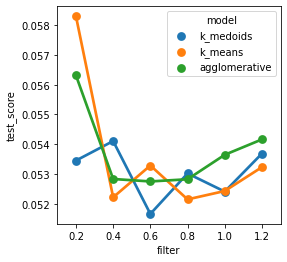

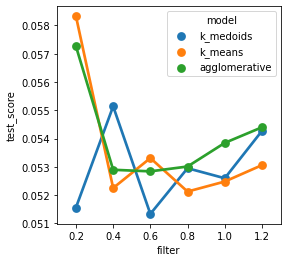

In [7]:
for i, strat in enumerate(k_compare['cluster_strat'].unique()):
    print(strat)
    df = k_compare.query('cluster_strat == @strat')
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
#    chart = sns.pointplot(ax=ax, data=df, x="filter", y='train_score', hue='model');
    chart = sns.pointplot(ax=ax, data=df, x="filter", y='test_score', hue='model');


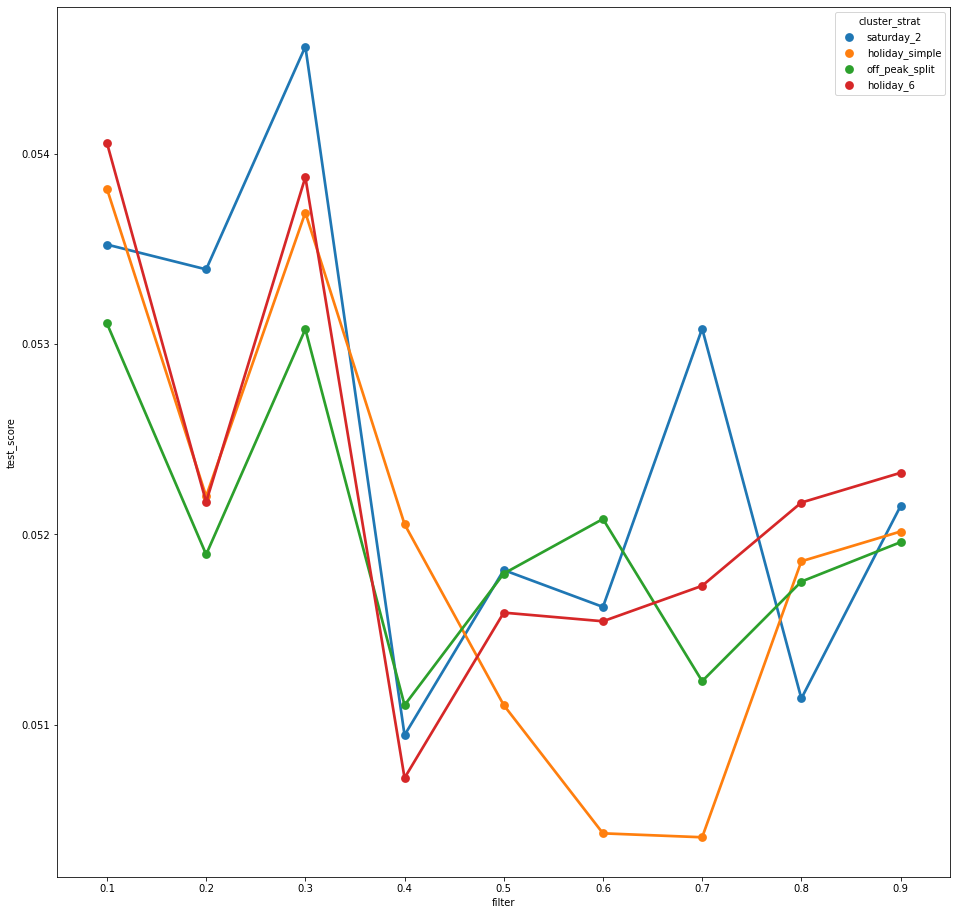

In [15]:
'''
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='train_score', hue='cluster_strat');
chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='test_score', hue='cluster_strat');
'''

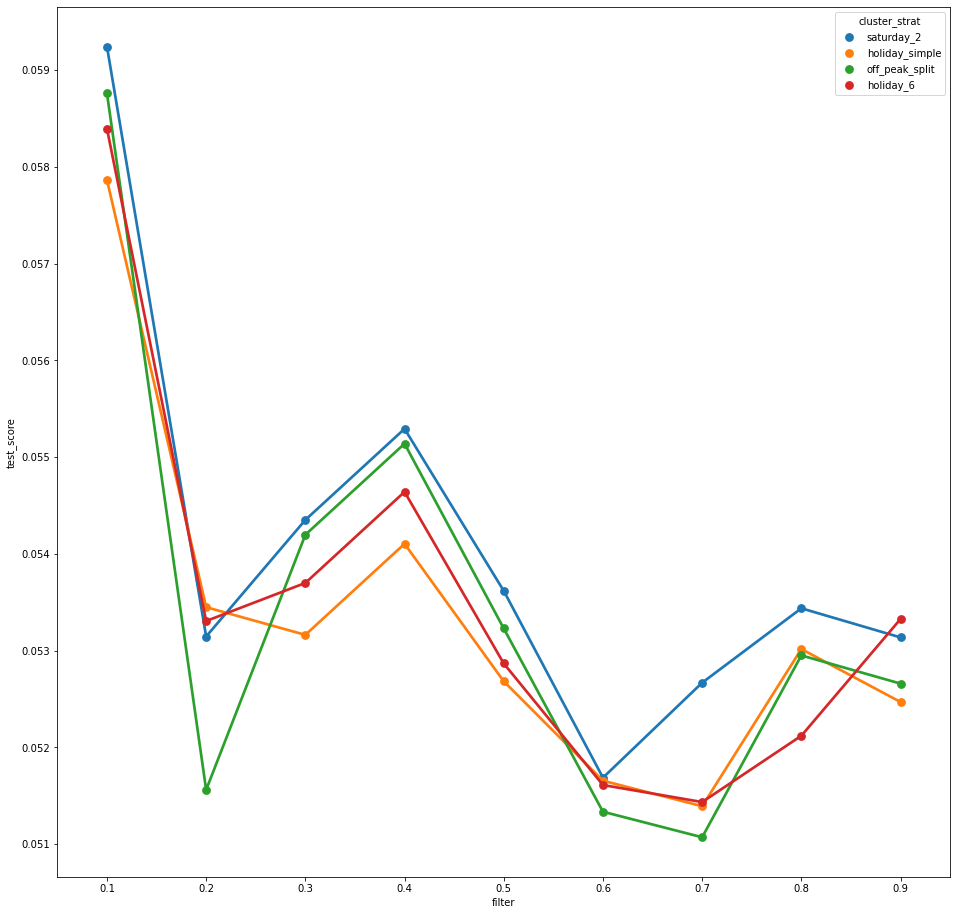

In [10]:
'''k_compare_1 = pd.read_csv('../Outputs/k_compare_1.csv')
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='train_score', hue='cluster_strat');
chart = sns.pointplot(ax=ax, data=k_compare_1, x="filter", y='test_score', hue='cluster_strat');
'''

In [ ]:
### Below are results of running the pipeline with different settings. I use holdout value of .3 for testing and then .005 for zindi.
### The results vary so much it is safer to use 0.3 holdout also when creating results for zini and checking that score for test set is good (<.052 would be good)

In [18]:
ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                             outlier_filter=0.007, 
                             holdout_strategy='random', holdout_test_size=0.005,
                             test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                             tw_cluster_strategy='off_peak_split', placement_method='gradient_descent', verbose=1,
                             lr=3e-3, n_epochs=400)


5 clusters created
using gradient descent clustering
5 placement sets created
Total size of test set: 32
Total size of train set: 6318
Score on test set: 0.04545677922958966
Score on train set: 0.03783066574240511 (avg distance per accident)


In [69]:
ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                             outlier_filter=0.005, 
                             holdout_strategy='random', holdout_test_size=0.005,
                             test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                             tw_cluster_strategy='off_peak_split', placement_method='gradient_descent', verbose=1,
                             lr=8e-3, n_epochs=400)


5 clusters created
using gradient descent clustering
5 placement sets created
Total size of test set: 32
Total size of train set: 6318
Score on test set: 0.050398969173522185
Score on train set: 0.040441300344994685 (avg distance per accident)


In [70]:
ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                             outlier_filter=0.006, 
                             holdout_strategy='random', holdout_test_size=0.005,
                             test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                             tw_cluster_strategy='off_peak_split', placement_method='gradient_descent', verbose=1,
                             lr=8e-3, n_epochs=400)


5 clusters created
using gradient descent clustering
5 placement sets created
Total size of test set: 32
Total size of train set: 6318
Score on test set: 0.04174273246180271
Score on train set: 0.041092172201001906 (avg distance per accident)


In [74]:
ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                             outlier_filter=0.005, 
                             holdout_strategy='random', holdout_test_size=0.005,
                             test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                             tw_cluster_strategy='holiday_simple', placement_method='gradient_descent', verbose=1,
                             lr=3e-3, n_epochs=400)


5 clusters created
using gradient descent clustering
5 placement sets created
Total size of test set: 32
Total size of train set: 6318
Score on test set: 0.051145431919451846
Score on train set: 0.041545669901975994 (avg distance per accident)


In [73]:
ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                             outlier_filter=0.006, 
                             holdout_strategy='random', holdout_test_size=0.005,
                             test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                             tw_cluster_strategy='holiday_simple', placement_method='gradient_descent', verbose=1,
                             lr=3e-3, n_epochs=400)


5 clusters created
using gradient descent clustering
5 placement sets created
Total size of test set: 32
Total size of train set: 6318
Score on test set: 0.03969852332712425
Score on train set: 0.03807655864325128 (avg distance per accident)


5 clusters created
using gradient descent clustering
Val loss: 0.043158192187547684


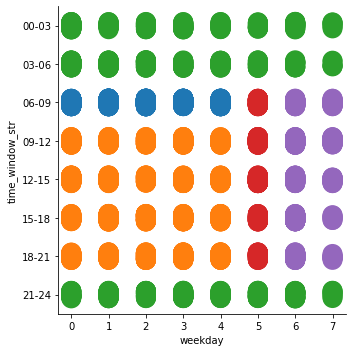

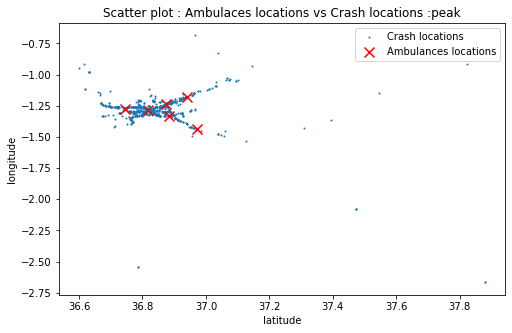

[[-1.1799288 36.940083 ]
 [-1.2881612 36.81635  ]
 [-1.2344279 36.87438  ]
 [-1.3333938 36.88303  ]
 [-1.4347937 36.97063  ]
 [-1.2724848 36.746387 ]]
Val loss: 0.053823038935661316


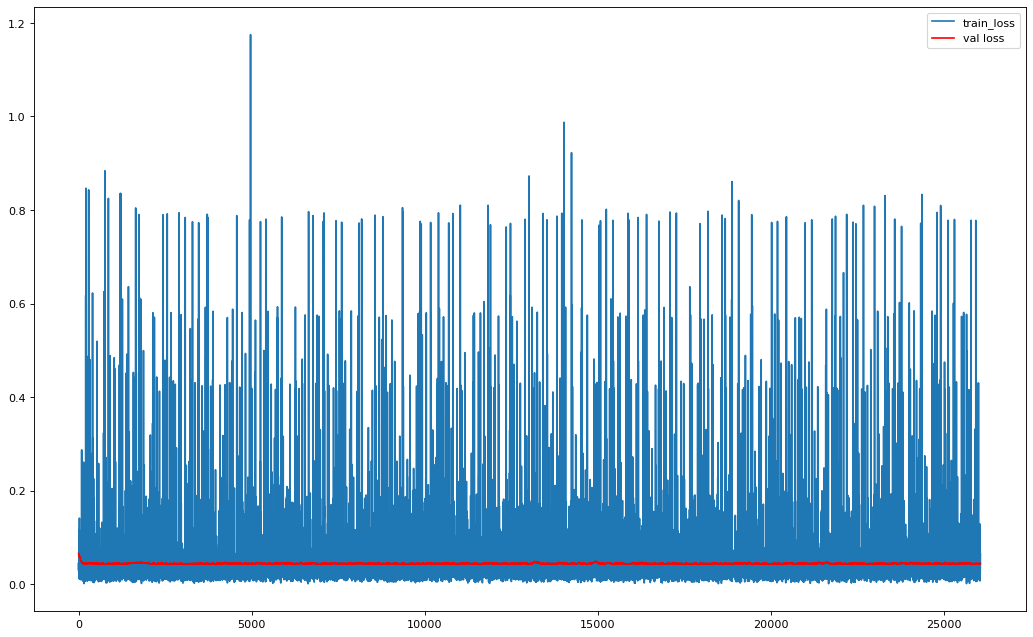

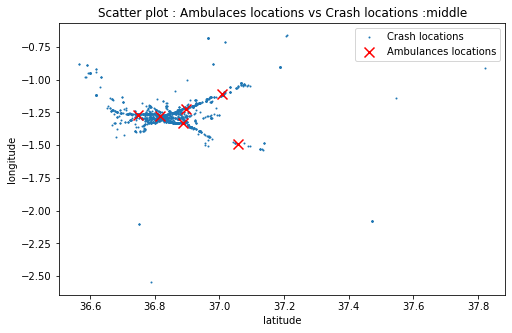

[[-1.3344351 36.887714 ]
 [-1.2756282 36.81624  ]
 [-1.225701  36.895092 ]
 [-1.1073457 37.007652 ]
 [-1.2728798 36.748238 ]
 [-1.4895062 37.058064 ]]
Val loss: 0.05201974883675575


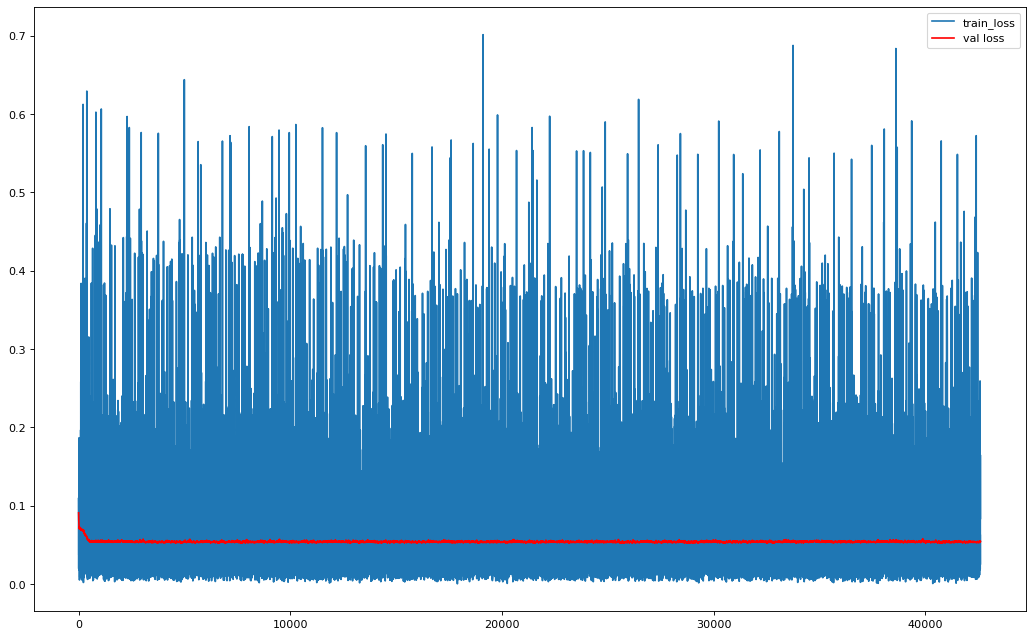

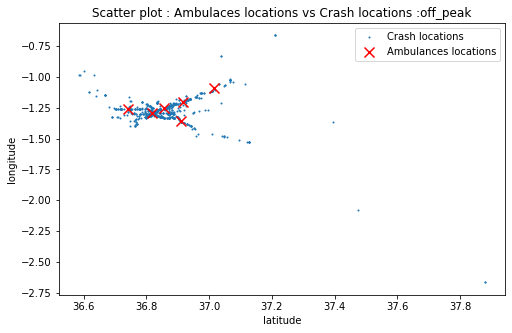

[[-1.2615544 36.74113  ]
 [-1.2930453 36.818798 ]
 [-1.3585097 36.90932  ]
 [-1.0899874 37.016716 ]
 [-1.2538003 36.85747  ]
 [-1.2000481 36.917202 ]]
Val loss: 0.06948745250701904


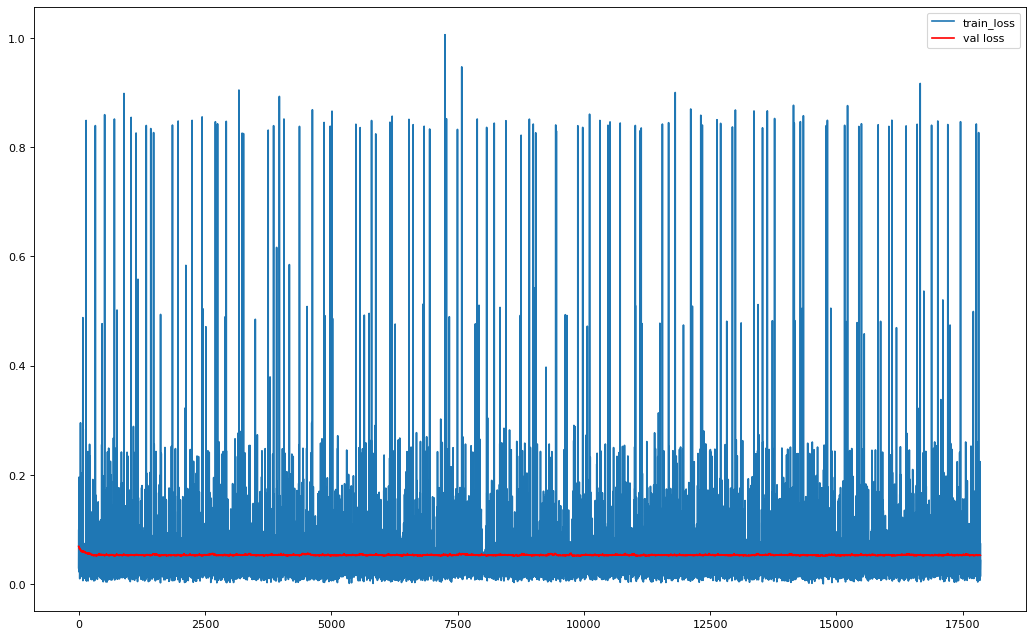

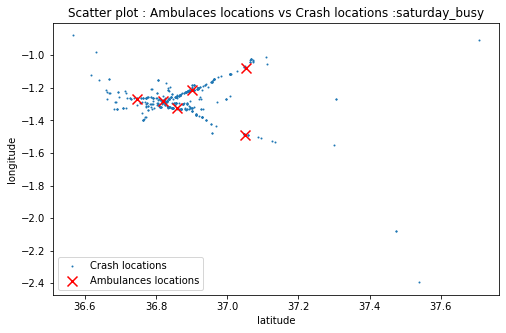

[[-1.0760727 37.053665 ]
 [-1.2115107 36.899876 ]
 [-1.2696879 36.747932 ]
 [-1.4882592 37.05027  ]
 [-1.2825394 36.82083  ]
 [-1.3264016 36.857746 ]]
Val loss: 0.07322573661804199


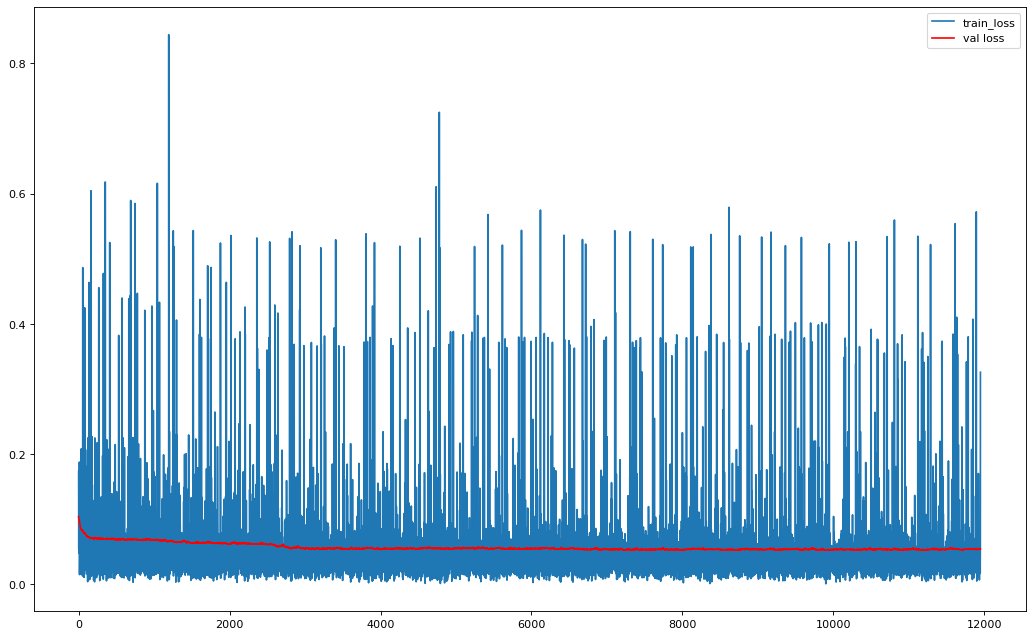

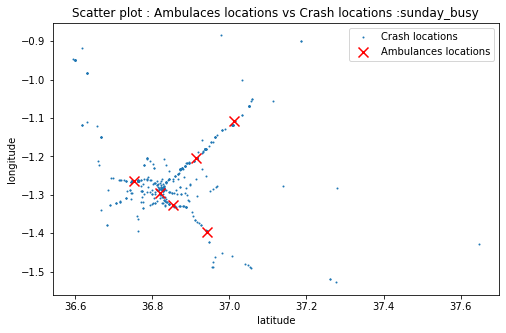

[[-1.3963531 36.94116  ]
 [-1.2047492 36.915043 ]
 [-1.2634645 36.75191  ]
 [-1.2943109 36.82109  ]
 [-1.1079372 37.01164  ]
 [-1.3263788 36.855415 ]]
5 placement sets created
Total size of test set: 1895
Total size of train set: 6318
Score on test set: 0.05282504075683012
Score on train set: 0.04942572305551831 (avg distance per accident)


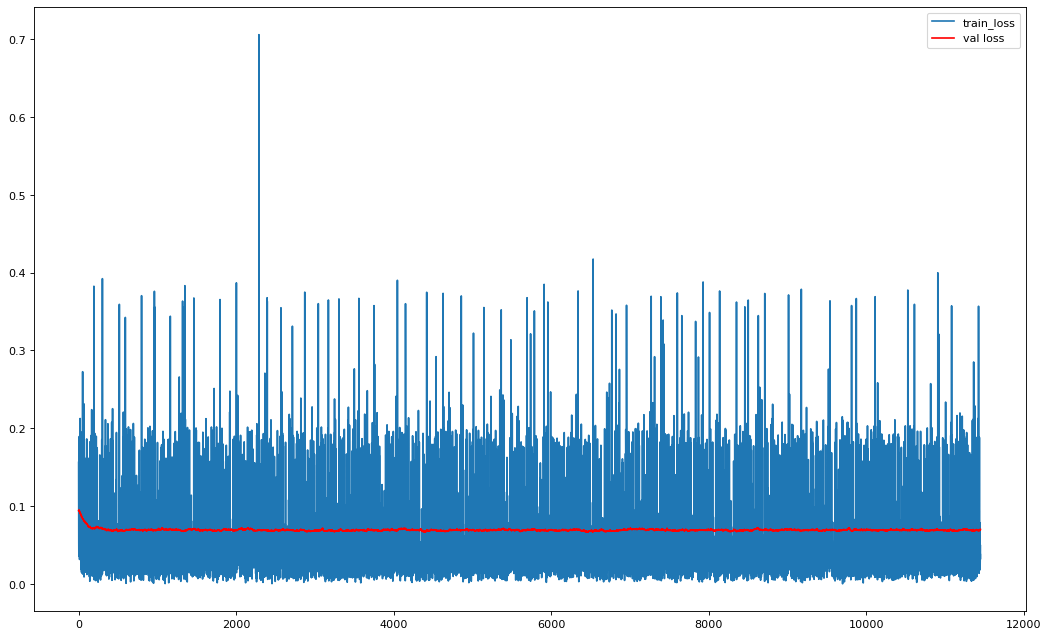

In [29]:
ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                             outlier_filter='hex_bin', 
                             holdout_strategy='random', holdout_test_size=0.3,
                             test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                             tw_cluster_strategy='off_peak_split', placement_method='gradient_descent', verbose=10,
                             lr=8e-3, n_epochs=50, batch_size = 2)
